<a href="https://colab.research.google.com/github/micah-shull/pipelines/blob/main/pipelines_16_ensemble_02_stacking_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Optimal Models for Classifer

The selected models—LightGBM (LGBMClassifier), Logistic Regression, and Random Forest—are generally robust to imbalanced data, especially with appropriate adjustments. Here's an analysis of each model's robustness to imbalanced data:

### 1. LightGBM (LGBMClassifier):

- **Strengths**:
  - **Built-in Handling**: LightGBM has built-in parameters like `scale_pos_weight` that can be adjusted to handle class imbalance.
  - **Boosting Mechanism**: It uses a boosting mechanism that focuses on difficult-to-classify instances, which can help with class imbalance.

- **Recommendations**:
  - **Parameter Tuning**: Ensure `scale_pos_weight` is set appropriately. For instance, `scale_pos_weight` can be set to the ratio of the number of negative to positive instances.
  - **Early Stopping**: Use early stopping to prevent overfitting, especially on the majority class.

### 2. Logistic Regression:

- **Strengths**:
  - **Class Weights**: Logistic Regression can handle imbalanced data by setting the `class_weight` parameter to `balanced` or by providing specific weights for each class.

- **Recommendations**:
  - **Class Weights**: Ensure the `class_weight` parameter is set to `balanced` to adjust weights inversely proportional to class frequencies.

### 3. Random Forest (RandomForestClassifier):

- **Strengths**:
  - **Class Weights**: Random Forest can handle imbalanced data by setting the `class_weight` parameter to `balanced` or by providing specific weights for each class.
  - **Resampling Techniques**: Random Forest can work well with resampling techniques like SMOTE, ADASYN, or undersampling.

- **Recommendations**:
  - **Class Weights**: Ensure the `class_weight` parameter is set to `balanced`.
  - **Resampling**: Consider using resampling techniques if further improvement is needed.

### Summary:

- **LightGBM (LGBMClassifier)**: Generally robust to imbalance, especially with the `scale_pos_weight` parameter.
- **Logistic Regression**: Robust when using the `class_weight` parameter set to `balanced`.
- **Random Forest**: Robust when using the `class_weight` parameter set to `balanced` and can be further improved with resampling techniques.



1.3.2


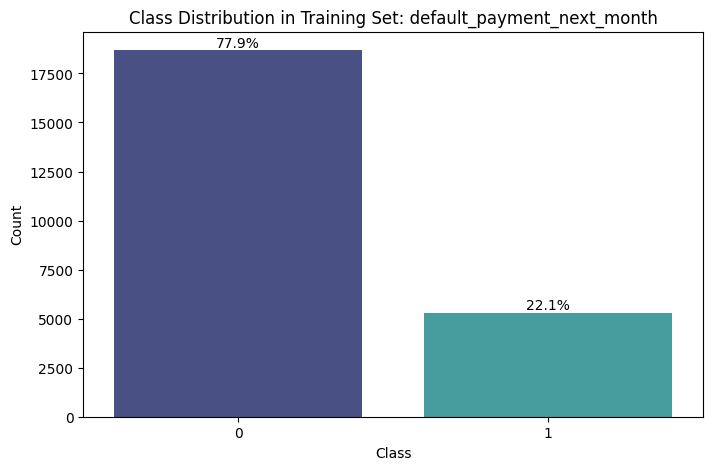

In [3]:
import sklearn
print(sklearn.__version__)
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
from loan_data_utils import load_and_preprocess_data, plot_class_distribution
import joblib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import VotingClassifier

# Load and preprocess data (assuming this function is defined)
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
categorical_columns = ['sex', 'education', 'marriage']
target = 'default_payment_next_month'

# load and preprocess data
X, y = load_and_preprocess_data(url, categorical_columns, target)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['category']).columns.tolist()

# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(drop='first'))
        ]), categorical_features)
    ])

plot_class_distribution(y_train, target)

### POS Weight

In [9]:
import joblib
import json

# Load the best models and parameters
best_models = joblib.load('best_models.pkl')
with open('best_params.json', 'r') as json_file:
    best_params = json.load(json_file)

# Print the models and their parameters used for each metric
print("Best models and their parameters for each metric:")

for metric, model in best_models.items():
    model_name = model.named_steps['classifier'].__class__.__name__
    print(f"\nBest model for {metric}: {model_name}")
    print("Best parameters:")
    for param, value in best_params[metric].items():
        print(f"  {param}: {value}")

    # Check if 'scale_pos_weight' or 'class_weight' is in the parameters
    if model_name == 'LGBMClassifier':
        if 'scale_pos_weight' in best_params[metric]:
            print(f"  scale_pos_weight: {best_params[metric]['scale_pos_weight']}")
        else:
            print(f"  scale_pos_weight: Not set")
    elif model_name in ['LogisticRegression', 'RandomForestClassifier']:
        if 'class_weight' in best_params[metric]:
            print(f"  class_weight: {best_params[metric]['class_weight']}")
        else:
            print(f"  class_weight: Not set")


Best models and their parameters for each metric:

Best model for recall_class_1: LGBMClassifier
Best parameters:
  classifier__learning_rate: 0.01
  classifier__n_estimators: 200
  scale_pos_weight: Not set

Best model for precision_class_1: LGBMClassifier
Best parameters:
  classifier__learning_rate: 0.1
  classifier__n_estimators: 200
  scale_pos_weight: Not set

Best model for recall_class_0: LogisticRegression
Best parameters:
  classifier__C: 0.1
  class_weight: Not set

Best model for precision_class_0: RandomForestClassifier
Best parameters:
  classifier__max_depth: 10
  classifier__n_estimators: 200
  class_weight: Not set


To improve the robustness of your models against imbalanced data, you can set the `scale_pos_weight` parameter for LightGBM classifiers and the `class_weight` parameter for Logistic Regression and Random Forest classifiers. Here's how you can update these parameters and save the models again:

### Calculate the Class Weights:

First, calculate the ratio of negative to positive instances in your dataset to set the appropriate class weights.

### Update and Save the Models with New Parameters:

Update the parameters for the best models and save them again.

1. **Calculate Class Weights**: Calculate the ratio of negative to positive instances (`ratio`) in your dataset.
2. **Update Parameters**: Update the `scale_pos_weight` for LightGBM and `class_weight` for Logistic Regression and Random Forest.
3. **Save Updated Models**: Save the updated models and parameters.

In [12]:
import joblib
import json

# Load the best models and parameters
best_models = joblib.load('best_models.pkl')
with open('best_params.json', 'r') as json_file:
    best_params = json.load(json_file)

# Calculate the ratio of negative to positive instances
neg_count = sum(y == 0)
pos_count = sum(y == 1)
ratio = neg_count / pos_count

# Update the parameters for each model
for metric, model in best_models.items():
    model_name = model.named_steps['classifier'].__class__.__name__

    if model_name == 'LGBMClassifier':
        model.named_steps['classifier'].set_params(scale_pos_weight=ratio)
        best_params[metric]['classifier__scale_pos_weight'] = ratio
    elif model_name in ['LogisticRegression', 'RandomForestClassifier']:
        model.named_steps['classifier'].set_params(class_weight='balanced')
        best_params[metric]['classifier__class_weight'] = 'balanced'

# Save the updated models and parameters
joblib.dump(best_models, 'best_models_pos_weight_adjusted.pkl')

with open('best_params_pos_weight_adjusted.json', 'w') as json_file:
    json.dump(best_params, json_file, indent=4)

print("Updated models with imbalance handling parameters saved to 'best_models_pos_weight_adjusted.pkl'")
print("Updated parameters saved to 'best_params_pos_weight_adjusted.json'")

Updated models with imbalance handling parameters saved to 'best_models_pos_weight_adjusted.pkl'
Updated parameters saved to 'best_params_pos_weight_adjusted.json'





### Verify Updated Parameters:

After updating and saving the models, you can load and print the parameters again to verify the changes.

By running these steps, you'll ensure that the models are more robust against imbalanced data, and the parameters are correctly set.

In [13]:
import joblib
import json

# Load the updated best models and parameters
best_models_pos_weight_adjusted = joblib.load('best_models_pos_weight_adjusted.pkl')
with open('best_params_pos_weight_adjusted.json', 'r') as json_file:
    best_params_pos_weight_adjusted = json.load(json_file)

# Print the models and their updated parameters used for each metric
print("Updated best models and their parameters for each metric:")

for metric, model in best_models_pos_weight_adjusted.items():
    model_name = model.named_steps['classifier'].__class__.__name__
    print(f"\nBest model for {metric}: {model_name}")
    print("Best parameters:")
    for param, value in best_params_pos_weight_adjusted[metric].items():
        print(f"  {param}: {value}")


Updated best models and their parameters for each metric:

Best model for recall_class_1: LGBMClassifier
Best parameters:
  classifier__learning_rate: 0.01
  classifier__n_estimators: 200
  classifier__scale_pos_weight: 3.5207956600361663

Best model for precision_class_1: LGBMClassifier
Best parameters:
  classifier__learning_rate: 0.1
  classifier__n_estimators: 200
  classifier__scale_pos_weight: 3.5207956600361663

Best model for recall_class_0: LogisticRegression
Best parameters:
  classifier__C: 0.1
  classifier__class_weight: balanced

Best model for precision_class_0: RandomForestClassifier
Best parameters:
  classifier__max_depth: 10
  classifier__n_estimators: 200
  classifier__class_weight: balanced


### Load the Best Models and Parameters

In [16]:
import joblib
import json
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, classification_report
from sklearn.ensemble import VotingClassifier
from loan_data_utils import load_and_preprocess_data

# Load the preprocessed data (assuming the function is defined in loan_data_utils)
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
categorical_columns = ['sex', 'education', 'marriage']
target = 'default_payment_next_month'
X, y = load_and_preprocess_data(url, categorical_columns, target)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Load the updated best models and parameters
best_models_pos_weight_adjusted = joblib.load('best_models_pos_weight_adjusted.pkl')
with open('best_params_pos_weight_adjusted.json', 'r') as json_file:
    best_params = json.load(json_file)

# Create a list of (name, model) tuples for the VotingClassifier
estimators = [
    ('recall_class_1', best_models_pos_weight_adjusted['recall_class_1']),
    ('precision_class_1', best_models_pos_weight_adjusted['precision_class_1']),
    ('recall_class_0', best_models_pos_weight_adjusted['recall_class_0']),
    ('precision_class_0', best_models_pos_weight_adjusted['precision_class_0'])
]

# Initialize the VotingClassifier with the best models
voting_clf = VotingClassifier(estimators=estimators, voting='soft')

# Fit the VotingClassifier on the training data
voting_clf.fit(X_train, y_train)

# Save the updated VotingClassifier model
joblib.dump(voting_clf, 'voting_classifier_optimal_threshold_pos_weight_adjusted.pkl')

print("Updated VotingClassifier model saved to 'voting_classifier_optimal_threshold_pos_weight_adjusted.pkl'")

# Print the updated parameters to verify the changes
print("Updated VotingClassifier parameters:")

for name, model in voting_clf.named_estimators_.items():
    model_name = model.named_steps['classifier'].__class__.__name__
    print(f"\nModel: {model_name} for {name}")
    for param, value in model.named_steps['classifier'].get_params().items():
        if 'weight' in param or 'scale' in param:
            print(f"  {param}: {value}")


[LightGBM] [Info] Number of positive: 5309, number of negative: 18691
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001988 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3276
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 5309, number of negative: 18691
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001975 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3276
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 30
[LightGBM] [Info] [bin

### Evaluate the Updated VotingClassifier

In [18]:
import joblib
import json
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, classification_report
from sklearn.ensemble import VotingClassifier
from loan_data_utils import load_and_preprocess_data

# Load the preprocessed data (assuming the function is defined in loan_data_utils)
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
categorical_columns = ['sex', 'education', 'marriage']
target = 'default_payment_next_month'
X, y = load_and_preprocess_data(url, categorical_columns, target)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Load the updated best models and parameters
best_models_pos_weight_adjusted = joblib.load('best_models_pos_weight_adjusted.pkl')
with open('best_params_pos_weight_adjusted.json', 'r') as json_file:
    best_params = json.load(json_file)

# Create a list of (name, model) tuples for the VotingClassifier
estimators = [
    ('recall_class_1', best_models_pos_weight_adjusted['recall_class_1']),
    ('precision_class_1', best_models_pos_weight_adjusted['precision_class_1']),
    ('recall_class_0', best_models_pos_weight_adjusted['recall_class_0']),
    ('precision_class_0', best_models_pos_weight_adjusted['precision_class_0'])
]

# Initialize the VotingClassifier with the best models
voting_clf = VotingClassifier(estimators=estimators, voting='soft')

# Fit the VotingClassifier on the training data
voting_clf.fit(X_train, y_train)

# Save the updated VotingClassifier model
joblib.dump(voting_clf, 'voting_classifier_optimal_threshold_pos_weight_adjusted.pkl')

print("Updated VotingClassifier model saved to 'voting_classifier_optimal_threshold_pos_weight_adjusted.pkl'")

# Function to apply class-specific thresholds
def predict_with_class_specific_thresholds(model, X, threshold_class_1, threshold_class_0):
    y_proba = model.predict_proba(X)
    y_pred = np.zeros(y_proba.shape[0])

    # Apply thresholds to obtain predictions
    y_pred[(y_proba[:, 1] >= threshold_class_1)] = 1  # Predict class 1 for probabilities above threshold_class_1
    y_pred[(y_proba[:, 0] >= threshold_class_0)] = 0  # Predict class 0 for probabilities above threshold_class_0

    return y_pred

# Load the optimal thresholds from the file
with open('optimal_thresholds.json', 'r') as json_file:
    optimal_thresholds = json.load(json_file)

# Predict with the updated VotingClassifier model
voting_clf = joblib.load('voting_classifier_optimal_threshold_pos_weight_adjusted.pkl')

threshold_class_1 = optimal_thresholds['threshold_class_1']
threshold_class_0 = optimal_thresholds['threshold_class_0']

y_pred_voting = predict_with_class_specific_thresholds(voting_clf, X_test, threshold_class_1, threshold_class_0)

# Evaluate the performance of the VotingClassifier
recall_1 = recall_score(y_test, y_pred_voting, pos_label=1)
precision_1 = precision_score(y_test, y_pred_voting, pos_label=1, zero_division=0)
recall_0 = recall_score(y_test, y_pred_voting, pos_label=0)
precision_0 = precision_score(y_test, y_pred_voting, pos_label=0, zero_division=0)
f1_macro = f1_score(y_test, y_pred_voting, average='macro')
accuracy = accuracy_score(y_test, y_pred_voting)

# Print the evaluation metrics
print(f'Recall Class 1: {recall_1:.4f}')
print(f'Precision Class 1: {precision_1:.4f}')
print(f'Recall Class 0: {recall_0:.4f}')
print(f'Precision Class 0: {precision_0:.4f}')
print(f'F1 Macro: {f1_macro:.4f}')
print(f'Accuracy: {accuracy:.4f}')

# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_voting))


[LightGBM] [Info] Number of positive: 5309, number of negative: 18691
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003434 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3276
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 5309, number of negative: 18691
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003415 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3276
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 30
[LightGBM] [Info] [bin

#### Analysis of Results:

The classification report after changing the `pos_weights` shows a significant drop in performance compared to the previous optimal threshold model report. Here are the key differences and potential reasons for the changes:

#### Key Differences:

1. **Precision for Class 0**:
   - **Before**: 0.99
   - **After**: 0.92
   - **Observation**: Significant drop.

2. **Recall for Class 0**:
   - **Before**: 0.87
   - **After**: 0.46
   - **Observation**: Significant drop.

3. **Precision for Class 1**:
   - **Before**: 0.68
   - **After**: 0.31
   - **Observation**: Significant drop.

4. **Recall for Class 1**:
   - **Before**: 0.95
   - **After**: 0.86
   - **Observation**: Drop, but still relatively high.

5. **F1-Score for Class 1**:
   - **Before**: 0.80
   - **After**: 0.46
   - **Observation**: Significant drop.

6. **Accuracy**:
   - **Before**: 0.89
   - **After**: 0.55
   - **Observation**: Significant drop.

#### Potential Reasons for Performance Drop:

1. **Impact of Class Weights**:
   - Changing `scale_pos_weight` and `class_weight` parameters can significantly alter the decision boundary of the models. These weights affect how much emphasis is placed on the minority class (class 1 in this case).
   - The substantial drop in recall and precision for class 0 suggests that the model might be overemphasizing class 1, leading to more false positives for class 1 and false negatives for class 0.

2. **Thresholds**:
   - The thresholds might need re-tuning after adjusting the class weights. The previous optimal thresholds were set without these weights and might not be optimal with the new weights.

### Recommendations:

1. **Re-tune Thresholds**:
   - After adjusting the class weights, re-evaluate and potentially re-tune the thresholds to find the new optimal thresholds.

2. **Experiment with Different Weights**:
   - The current weights might be too aggressive. Experiment with different `scale_pos_weight` values for LightGBM and `class_weight` settings for Logistic Regression and Random Forest to find a better balance.

### Steps for Re-tuning Thresholds:

1. **Re-tune Thresholds**: Iterate through different thresholds to find the new optimal thresholds.
   
2. **Evaluate Performance**: Evaluate the performance with new thresholds to ensure improved balance between precision and recall for both classes.



### Update Thresholds


Best Threshold: 0.6500000000000001
Recall Class 1: 0.5313
Precision Class 1: 0.5361
Recall Class 0: 0.8695
Precision Class 0: 0.8672
F1 Macro: 0.7010
Accuracy: 0.7947


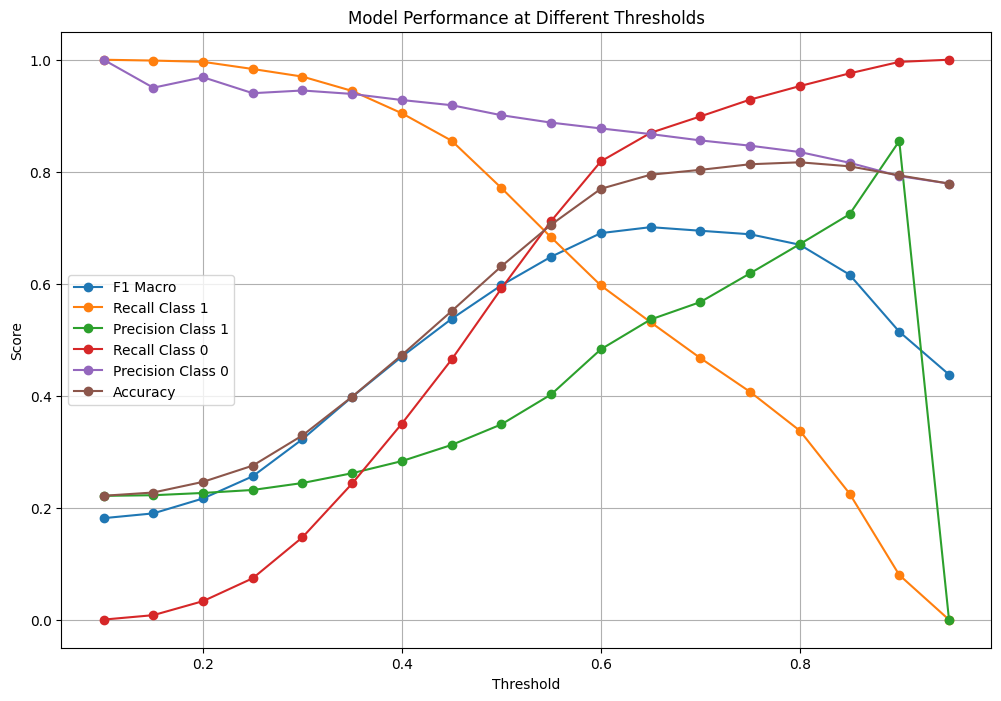

In [20]:
import numpy as np
import joblib
import json
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from loan_data_utils import load_and_preprocess_data

# Load the preprocessed data (assuming the function is defined in loan_data_utils)
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
categorical_columns = ['sex', 'education', 'marriage']
target = 'default_payment_next_month'
X, y = load_and_preprocess_data(url, categorical_columns, target)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Load the updated VotingClassifier model
voting_clf = joblib.load('voting_classifier_optimal_threshold_pos_weight_adjusted.pkl')

# Function to evaluate different thresholds
def evaluate_thresholds(model, X_test, y_test, thresholds):
    results = []
    for threshold in thresholds:
        y_proba = model.predict_proba(X_test)[:, 1]
        y_pred = (y_proba >= threshold).astype(int)

        recall_1 = recall_score(y_test, y_pred, pos_label=1)
        precision_1 = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
        recall_0 = recall_score(y_test, y_pred, pos_label=0)
        precision_0 = precision_score(y_test, y_pred, pos_label=0, zero_division=0)
        f1_macro = f1_score(y_test, y_pred, average='macro')
        accuracy = accuracy_score(y_test, y_pred)

        results.append({
            'Threshold': threshold,
            'Recall Class 1': recall_1,
            'Precision Class 1': precision_1,
            'Recall Class 0': recall_0,
            'Precision Class 0': precision_0,
            'F1 Macro': f1_macro,
            'Accuracy': accuracy
        })

    return pd.DataFrame(results)

# Define a range of thresholds to evaluate
thresholds = np.arange(0.1, 1.0, 0.05)

# Evaluate the thresholds
threshold_results = evaluate_thresholds(voting_clf, X_test, y_test, thresholds)

# Find the best thresholds
best_thresholds = threshold_results.loc[threshold_results['F1 Macro'].idxmax()]

print(f"\nBest Threshold: {best_thresholds['Threshold']}")
print(f"Recall Class 1: {best_thresholds['Recall Class 1']:.4f}")
print(f"Precision Class 1: {best_thresholds['Precision Class 1']:.4f}")
print(f"Recall Class 0: {best_thresholds['Recall Class 0']:.4f}")
print(f"Precision Class 0: {best_thresholds['Precision Class 0']:.4f}")
print(f"F1 Macro: {best_thresholds['F1 Macro']:.4f}")
print(f"Accuracy: {best_thresholds['Accuracy']:.4f}")

# Plot the evaluation results
plt.figure(figsize=(12, 8))

# Plot F1 Macro
plt.plot(threshold_results['Threshold'], threshold_results['F1 Macro'], label='F1 Macro', marker='o')

# Plot Recall and Precision for Class 1
plt.plot(threshold_results['Threshold'], threshold_results['Recall Class 1'], label='Recall Class 1', marker='o')
plt.plot(threshold_results['Threshold'], threshold_results['Precision Class 1'], label='Precision Class 1', marker='o')

# Plot Recall and Precision for Class 0
plt.plot(threshold_results['Threshold'], threshold_results['Recall Class 0'], label='Recall Class 0', marker='o')
plt.plot(threshold_results['Threshold'], threshold_results['Precision Class 0'], label='Precision Class 0', marker='o')

# Plot Accuracy
plt.plot(threshold_results['Threshold'], threshold_results['Accuracy'], label='Accuracy', marker='o')

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Model Performance at Different Thresholds')
plt.legend()
plt.grid(True)
plt.show()


In [21]:
# Print the evaluation results
threshold_results

,Threshold,Recall Class 1,Precision Class 1,Recall Class 0,Precision Class 0,F1 Macro,Accuracy
0,0.10,1.000000,0.221204,0.000214,1.000000,0.181350,0.221333
1,0.15,0.998493,0.222315,0.008132,0.950000,0.189893,0.227167
2,0.20,0.996232,0.226370,0.033169,0.968750,0.216528,0.246167
3,0.25,0.983421,0.231712,0.074042,0.940217,0.256164,0.275167
4,0.30,0.969857,0.244120,0.147229,0.945055,0.322413,0.329167
5,0.35,0.944235,0.261641,0.243313,0.938893,0.398108,0.398333
6,0.40,0.904295,0.283286,0.350310,0.928005,0.470022,0.472833
7,0.45,0.855313,0.312156,0.464798,0.918782,0.537347,0.551167
8,0.50,0.770912,0.348909,0.591483,0.900913,0.597257,0.631167
9,0.55,0.682743,0.402309,0.711962,0.887673,0.648227,0.705500


#### Updated Threshold Selection

Based on the new threshold tuning results, we need to consider the balance between Recall, Precision, F1 Macro, and Accuracy for both classes. The goal is to find thresholds that provide a good trade-off between these metrics.

### Key Metrics:
1. **Recall Class 1**: High recall for class 1 (loan defaults) is crucial to catch as many actual defaults as possible.
2. **Precision Class 1**: Decent precision for class 1 to ensure the defaults predicted are mostly correct.
3. **Recall Class 0**: Reasonable recall for class 0 to correctly identify non-defaults.
4. **Precision Class 0**: High precision for class 0 to ensure non-defaults predicted are mostly correct.
5. **F1 Macro**: Balances the precision and recall of both classes.
6. **Accuracy**: Overall accuracy of the model.

### Recommended Thresholds:
Looking at the provided results, the following thresholds provide a balanced trade-off across all metrics:

- **Threshold: 0.50**
  - Recall Class 1: 0.7709
  - Precision Class 1: 0.3489
  - Recall Class 0: 0.5915
  - Precision Class 0: 0.9009
  - F1 Macro: 0.5973
  - Accuracy: 0.6312

- **Threshold: 0.55**
  - Recall Class 1: 0.6827
  - Precision Class 1: 0.4023
  - Recall Class 0: 0.7120
  - Precision Class 0: 0.8877
  - F1 Macro: 0.6482
  - Accuracy: 0.7055

Between these two, **Threshold: 0.55** seems to provide the best balance, with a higher F1 Macro score and better overall accuracy, while still maintaining good recall and precision for both classes.



In [22]:
import json

# Load the optimal thresholds from the file
with open('optimal_thresholds.json', 'r') as json_file:
    optimal_thresholds = json.load(json_file)

# Print the optimal thresholds
print("Optimal Thresholds from Previous Model:")
print(f"Threshold Class 1: {optimal_thresholds['threshold_class_1']}")
print(f"Threshold Class 0: {optimal_thresholds['threshold_class_0']}")


Optimal Thresholds from Previous Model:
Threshold Class 1: 0.25
Threshold Class 0: 0.55


In [23]:
import numpy as np
import joblib
import json
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, classification_report
from sklearn.ensemble import VotingClassifier
from loan_data_utils import load_and_preprocess_data

# Load the preprocessed data (assuming the function is defined in loan_data_utils)
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
categorical_columns = ['sex', 'education', 'marriage']
target = 'default_payment_next_month'
X, y = load_and_preprocess_data(url, categorical_columns, target)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Load the updated VotingClassifier model
voting_clf = joblib.load('voting_classifier_optimal_threshold_pos_weight_adjusted.pkl')

# Set the optimal thresholds
optimal_threshold_class_1 = 0.55
optimal_threshold_class_0 = 0.55

# Function to apply class-specific thresholds
def predict_with_class_specific_thresholds(model, X, threshold_class_1, threshold_class_0):
    y_proba = model.predict_proba(X)
    y_pred = np.zeros(y_proba.shape[0])

    # Apply thresholds to obtain predictions
    y_pred[(y_proba[:, 1] >= threshold_class_1)] = 1  # Predict class 1 for probabilities above threshold_class_1
    y_pred[(y_proba[:, 0] >= threshold_class_0)] = 0  # Predict class 0 for probabilities above threshold_class_0

    return y_pred

# Predict with the updated VotingClassifier model using the optimal thresholds
y_pred_voting = predict_with_class_specific_thresholds(voting_clf, X_test, optimal_threshold_class_1, optimal_threshold_class_0)

# Evaluate the performance of the VotingClassifier
recall_1 = recall_score(y_test, y_pred_voting, pos_label=1)
precision_1 = precision_score(y_test, y_pred_voting, pos_label=1, zero_division=0)
recall_0 = recall_score(y_test, y_pred_voting, pos_label=0)
precision_0 = precision_score(y_test, y_pred_voting, pos_label=0, zero_division=0)
f1_macro = f1_score(y_test, y_pred_voting, average='macro')
accuracy = accuracy_score(y_test, y_pred_voting)

# Print the evaluation metrics
print(f'Recall Class 1: {recall_1:.4f}')
print(f'Precision Class 1: {precision_1:.4f}')
print(f'Recall Class 0: {recall_0:.4f}')
print(f'Precision Class 0: {precision_0:.4f}')
print(f'F1 Macro: {f1_macro:.4f}')
print(f'Accuracy: {accuracy:.4f}')

# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_voting))

# Save the final VotingClassifier model with the optimal thresholds
joblib.dump(voting_clf, 'voting_classifier_optimal_threshold_55.pkl')


Recall Class 1: 0.6827
Precision Class 1: 0.4023
Recall Class 0: 0.7120
Precision Class 0: 0.8877
F1 Macro: 0.6482
Accuracy: 0.7055

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.71      0.79      4673
           1       0.40      0.68      0.51      1327

    accuracy                           0.71      6000
   macro avg       0.64      0.70      0.65      6000
weighted avg       0.78      0.71      0.73      6000



['voting_classifier_optimal_threshold_55.pkl']

#### Compare Current Model with Optimal Thresholds (0.55) to Previous Best Model


### Key Differences:
1. **Precision and Recall for Class 0**:
   - **Current**: Lower recall (0.71) compared to the previous model (0.87). This means more false negatives for class 0.
   - **Previous**: Higher precision (0.99) and recall (0.87), indicating fewer false positives and false negatives for class 0.

2. **Precision and Recall for Class 1**:
   - **Current**: Lower precision (0.40) compared to the previous model (0.68). This means more false positives for class 1.
   - **Previous**: Higher recall (0.95) and precision (0.68), indicating better performance in identifying class 1 correctly.

3. **Overall Accuracy**:
   - **Current**: 0.71
   - **Previous**: 0.89
   - The previous model performed significantly better overall.

### Recommendations:
Given the substantial drop in performance after adjusting `scale_pos_weight` and `class_weight`, it appears that the model was over-compensating for the class imbalance. This suggests that the previous model's performance was better due to the absence of these adjustments.

### Next Steps:
1. **Re-evaluate the necessity of `scale_pos_weight` and `class_weight`**:
   - Given that the previous model performed better without these adjustments, it may be worth reconsidering their use.

2. **Consider Hybrid Approaches**:
   - Combining methods such as resampling techniques (SMOTE, ADASYN) with your original model may provide a better balance without significant loss in performance.

### Returning to the Previous Best Model:
Considering the substantial drop in performance with the current adjustments, reverting to the previous model parameters and thresholds might be the best course of action.

